In [1]:
import sys
import os
from copy import deepcopy
sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from webapp.utils.azure_utils import KeyVault, DataLake
import dask.dataframe as dd
import dask.array as da

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, TorchNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MultiLoss, MAE, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
# Connect to Storage Account
vault = KeyVault(keyVaultName = "keyvaultdva2022")
storage_credential = vault.get_secret(secretName = "storagePrimaryKey")
storage = DataLake(account_name = "storageaccountdva", credential = storage_credential)
file_system = "energyhub"

In [3]:
# Read data:
metadata = storage.pandas_read(file_system, directory = "data_parq/metadata", file_name = "metadata.parq")
weather = storage.pandas_read(file_system, directory = "data_parq/weather", file_name = "weather.parq")
electricity = storage.pandas_read(file_system, directory = "data_parq/meters", file_name = "electricity.parq")

In [11]:
metadata

,site_id,building_id_kaggle,site_id_kaggle,primary_space_usage,sub_primary_space_usage,sq_meter,sq_feet,latitude,longitude,timezone,...,year_built,date_opened,number_of_floors,occupants,energy_stars_core,eui,site_eui,source_eui,leed_level,rating
building_id,,,,,,,,,,,,,,,,,,,,,
Panther_lodging_Dean,Panther,NaN,0.0,Lodging/residential,Residence Hall,508.8,5477.0,28.517689,-81.379039,US/Eastern,...,1989.0,NaN,NaN,NaN,NaN,271,NaN,NaN,None,NaN
Panther_lodging_Shelia,Panther,NaN,0.0,Lodging/residential,Residence Hall,929.0,10000.0,28.517689,-81.379039,US/Eastern,...,1992.0,NaN,NaN,NaN,NaN,62,NaN,NaN,None,NaN
Panther_lodging_Ricky,Panther,NaN,0.0,Lodging/residential,Residence Hall,483.1,5200.0,28.517689,-81.379039,US/Eastern,...,2016.0,NaN,NaN,NaN,NaN,534,NaN,NaN,None,NaN
Panther_education_Rosalie,Panther,0.0,0.0,Education,Research,690.5,7432.0,28.517689,-81.379039,US/Eastern,...,2008.0,NaN,NaN,NaN,NaN,276,NaN,NaN,None,NaN
Panther_education_Misty,Panther,1.0,0.0,Education,Research,252.7,2720.0,28.517689,-81.379039,US/Eastern,...,2004.0,NaN,NaN,NaN,NaN,375,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mouse_health_Estela,Mouse,NaN,NaN,Healthcare,Hospital,17193.0,185064.0,51.521939,-0.120069,Europe/London,...,1936.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,F
Mouse_health_Ileana,Mouse,NaN,NaN,Healthcare,Hospital,5399.0,58114.0,51.521939,-0.120069,Europe/London,...,1954.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,F
Mouse_health_Buddy,Mouse,NaN,NaN,Healthcare,Hospital,1749.0,18826.0,51.521939,-0.120069,Europe/London,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,F


In [4]:
sites = metadata.site_id.unique()

In [5]:
def weather_fillna(df):
   df = deepcopy(df)

   # Interpolate missing values:
   cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precipitation_depth_1_hr',
      'precipitation_depth_6_hr', 'sea_level_pressure', 'wind_direction',
      'wind_speed']

   for col in cols:
      df[col] = df[col].interpolate(method = "linear").fillna(method = "bfill")

   return df

In [6]:
df_w = []
for site in sites:
    df_w.append(weather_fillna(weather[weather["site_id"] == site]))

weather = pd.concat(df_w)
weather.isna().sum()*100/len(weather)

timestamp                    0.000000
site_id                      0.000000
air_temperature              0.000000
cloud_coverage              10.182205
dew_temperature              0.000000
precipitation_depth_1_hr    26.437799
precipitation_depth_6_hr     5.284359
sea_level_pressure           5.284359
wind_direction               0.000000
wind_speed                   0.000000
dtype: float64

In [7]:
# Drop columns with too many missing values:
weather_cols = ['timestamp', 'site_id', 'air_temperature', 
       'dew_temperature', 'sea_level_pressure', 'wind_direction',
       'wind_speed']
weather = weather[weather_cols]

In [8]:
# Add site_id to electricity:
e = pd.merge(electricity, metadata[['building_id', 'site_id']], on = "building_id", how = "left")

In [9]:
# Use one site only:
site = sites[0]
m = metadata[metadata["site_id"] == site]
m = metadata[['building_id', 'site_id', 'sq_meter']]
w = weather[weather["site_id"] == site]
e = e[e["site_id"] == site]
buildings = list(e.building_id.unique())

In [10]:
e.isna().sum()*100/len(e)

timestamp       0.00000
building_id     0.00000
electricity    19.81239
site_id         0.00000
dtype: float64

In [11]:
def electricity_fillna(df):
   df = deepcopy(df)

   if df["electricity"].isna().sum()*100/len(df) < 50:
    df["electricity"] = df["electricity"].interpolate(method = "linear").fillna(method = "bfill")
    return df

df_e = []
for building in buildings:
    df_e.append(electricity_fillna(e[e["building_id"] == building]))

e = pd.concat(df_e)

In [12]:
e.isna().sum()*100/len(e)

timestamp      0.0
building_id    0.0
electricity    0.0
site_id        0.0
dtype: float64

In [13]:
# Merge datasets: 
df = pd.merge(e, m, on = ["building_id", "site_id"], how = "left")
df = pd.merge(df, w, on = ["site_id", "timestamp"], how = "left")

In [14]:
# Convert ts to datetime:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [15]:
# Convert site id and building id to category:
df["building_id"] = df["building_id"].astype("category")
df["site_id"] = df["site_id"].astype("category")

In [16]:
# Add cos, sin time features:
def time_features(df):
    df = deepcopy(df)

    df = df.sort_values(by = "timestamp")
    df["time_idx"] = df.index

    df["time_norm"] = 2 * np.pi * df["time_idx"] / df["time_idx"].max()
    df["cos_time"] = np.cos(df["time_norm"])
    df["sin_time"] = np.sin(df["time_norm"])

    return df

buildings = df.building_id.unique()
df_df = []
for building in buildings:
    df_df.append(time_features(df[df["building_id"] == building]))

df = pd.concat(df_df)

In [17]:
df.isna().sum()*100/len(df)

timestamp             0.0
building_id           0.0
electricity           0.0
site_id               0.0
sq_meter              0.0
air_temperature       0.0
dew_temperature       0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
time_idx              0.0
time_norm             0.0
cos_time              0.0
sin_time              0.0
dtype: float64

In [18]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

In [19]:
df.columns

Index(['timestamp', 'building_id', 'electricity', 'site_id', 'sq_meter',
       'air_temperature', 'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'time_idx', 'time_norm', 'cos_time',
       'sin_time'],
      dtype='object')

In [20]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="electricity",
    group_ids=["building_id"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["building_id"],
    static_reals=["sq_meter"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['air_temperature', 'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'time_idx', 'time_norm', 'cos_time',
       'sin_time'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "electricity"],
    target_normalizer=GroupNormalizer(
        groups=["building_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [21]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [22]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [23]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [25]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 32.3k


c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1079: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_forecasting\data\timeseries.py:1657: UserWarning: Creating a tensor from a list of num

suggested learning rate: 5.888436553555889e-06


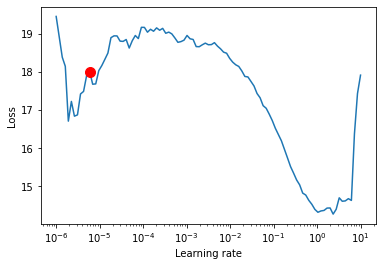

C:\Users\nmert\AppData\Local\Temp\ipykernel_10348\3631724801.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [26]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [27]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 32.3k


c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [28]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.7 K 
3  | prescalers                         | ModuleDict                      | 240   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        

Global seed set to 42
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 31/31 [00:07<00:00,  4.20it/s, loss=2.45, v_num=0, train_loss_step=3.530, val_loss=1.650, train_loss_epoch=2.370]


In [29]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [30]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(5.4230)

In [31]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

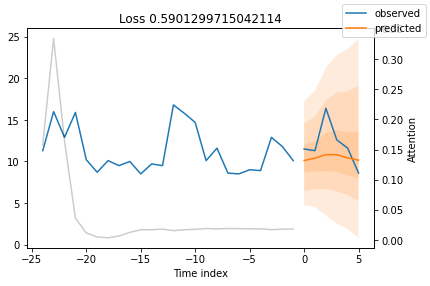

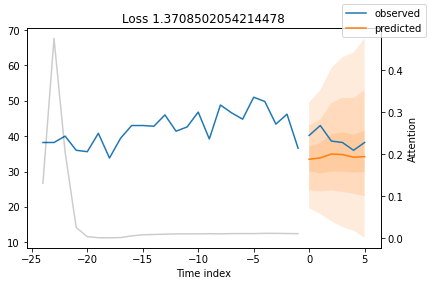

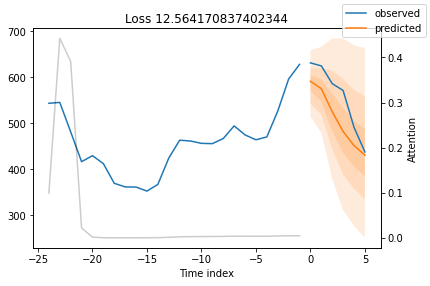

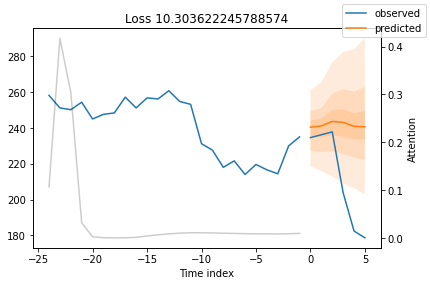

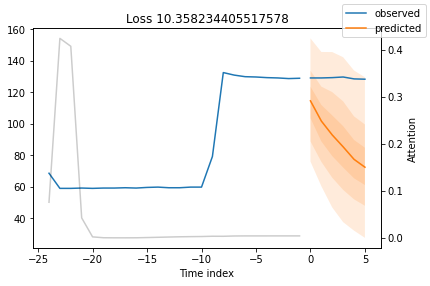

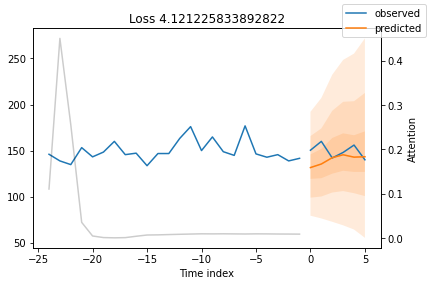

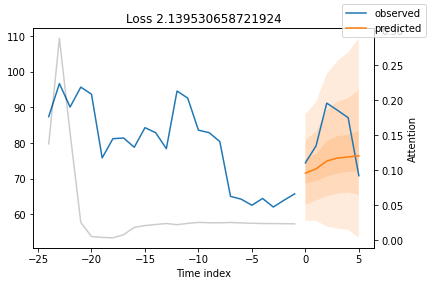

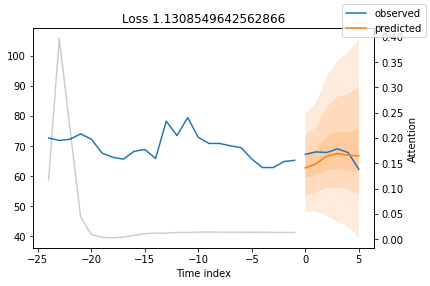

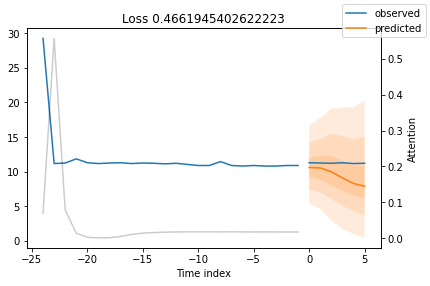

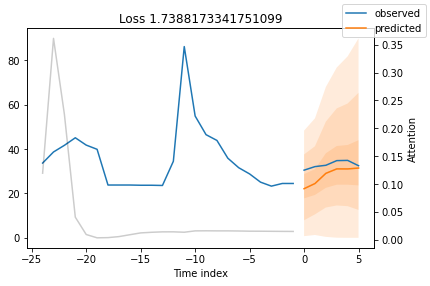

In [32]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

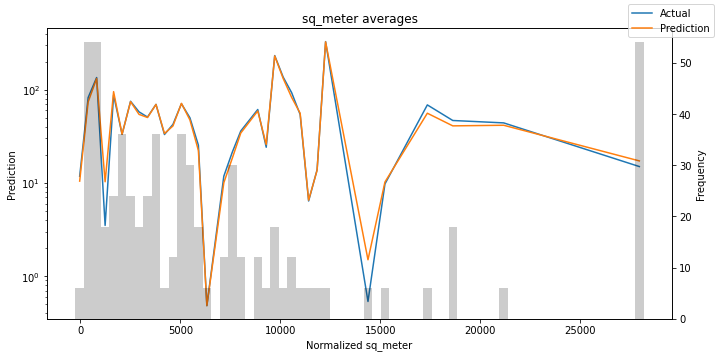

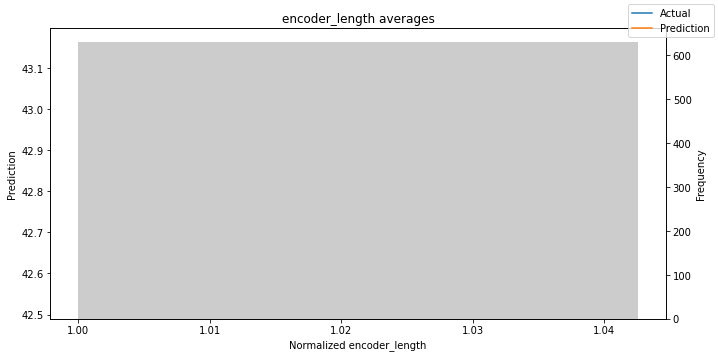

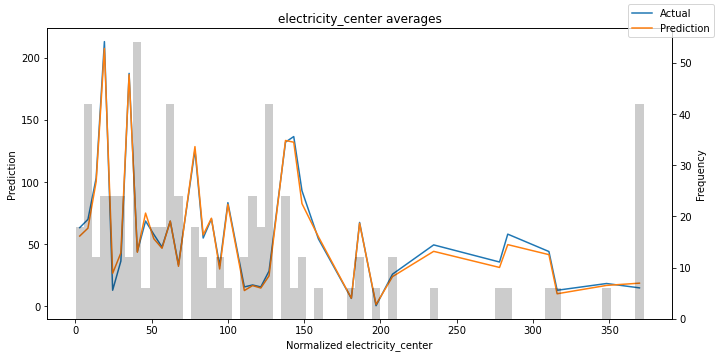

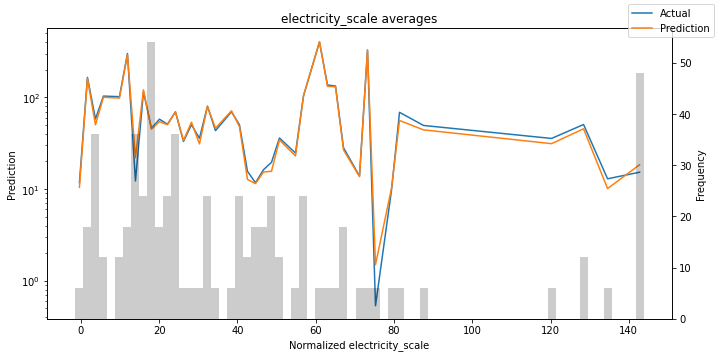

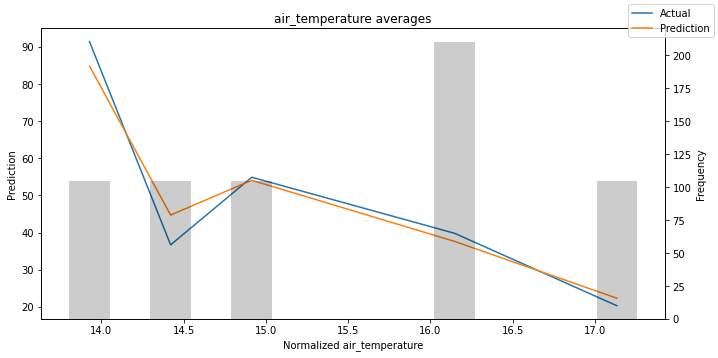

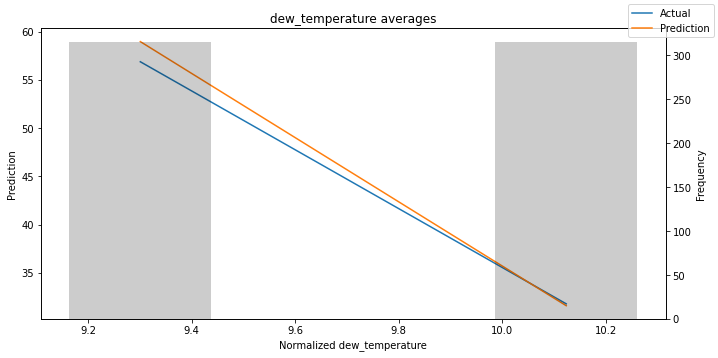

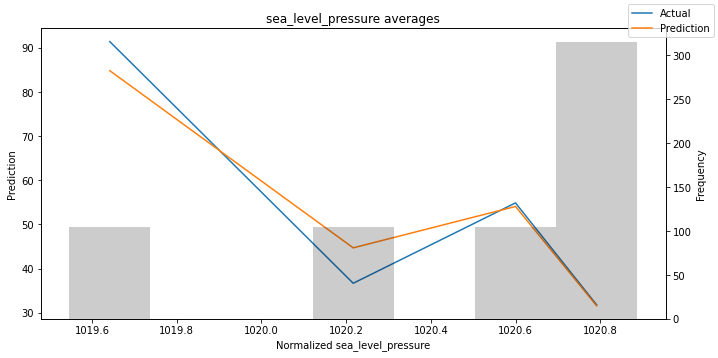

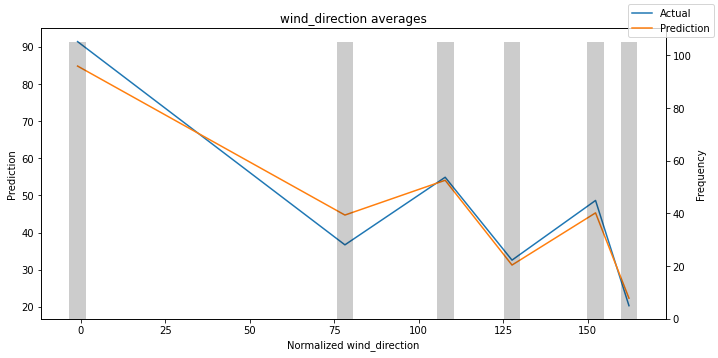

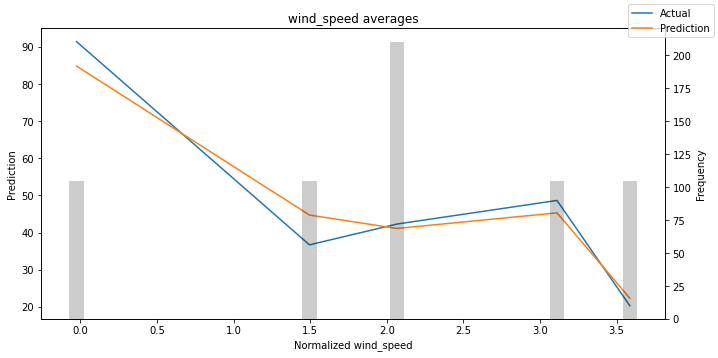

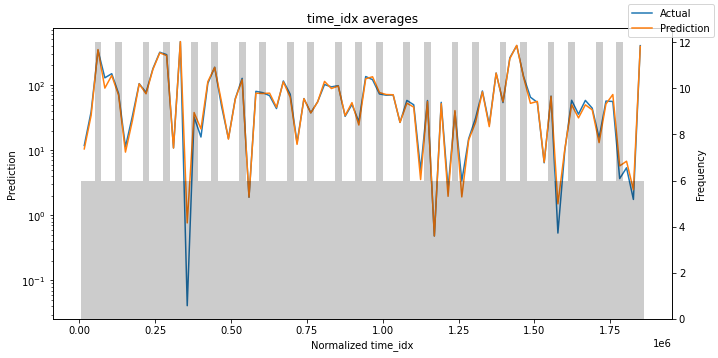

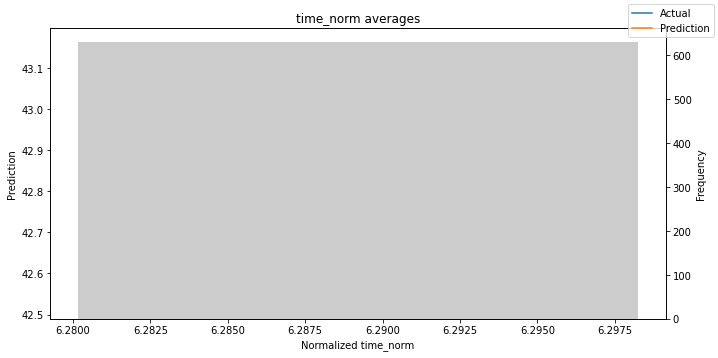

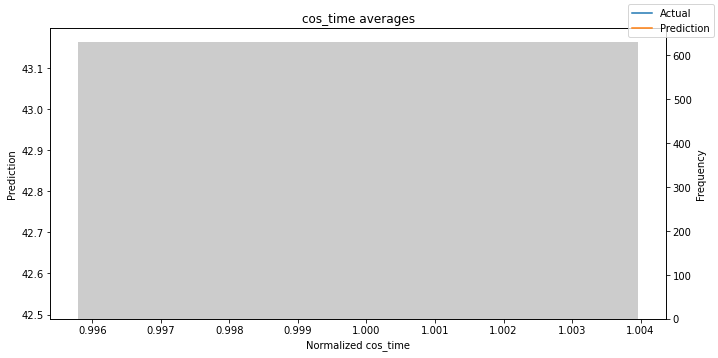

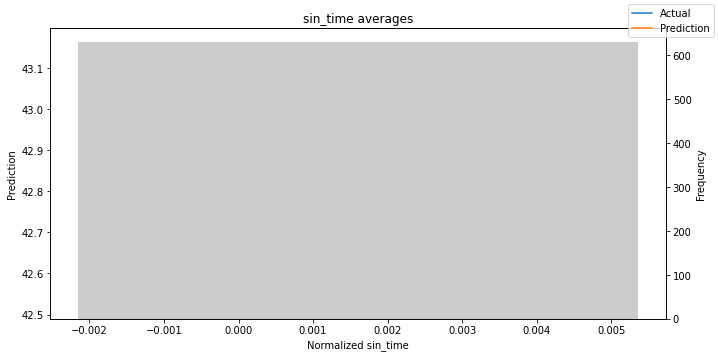

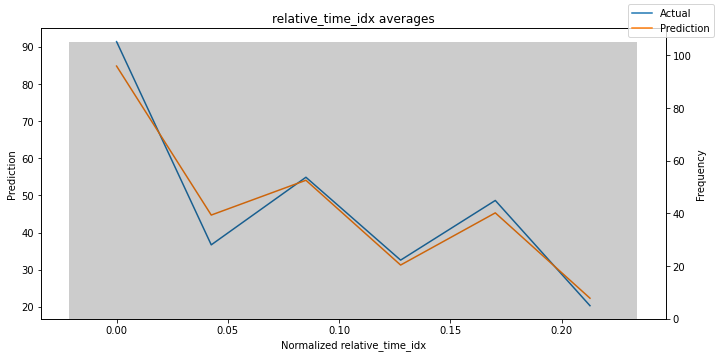

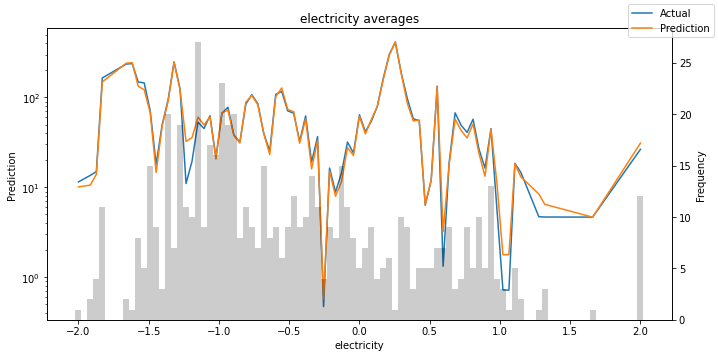

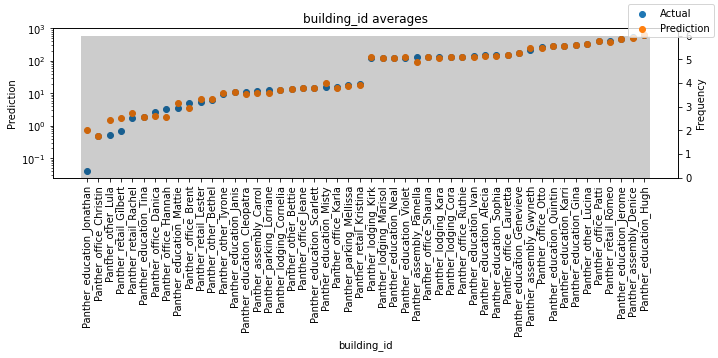

In [33]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x342 with 1 Axes>,
 'decoder_variables': <Figure size 504x324 with 1 Axes>}

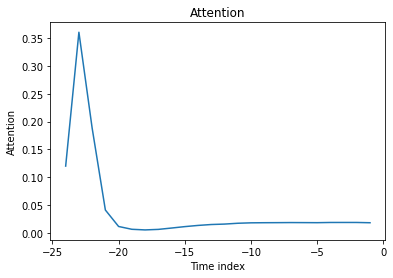

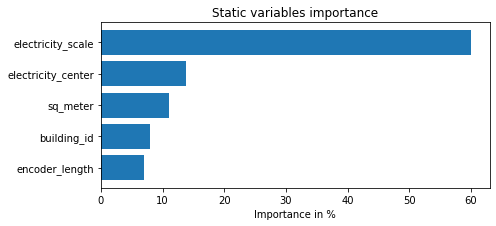

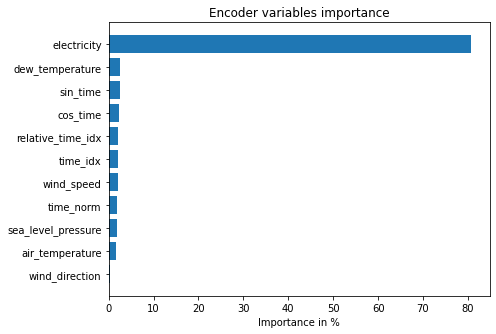

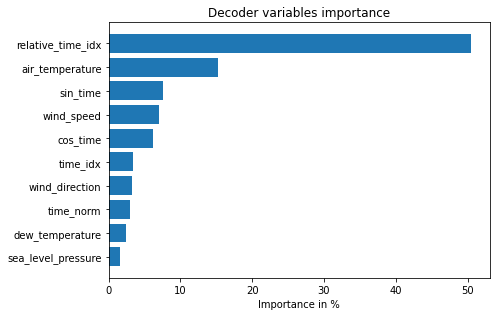

In [34]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)